# Фильтр Блума со счётом

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hashlib

## 1. Реализация Фильтра Блума

In [ ]:
class CountingBloomFilter:
    def __init__(self, size, num_hashes):
        self.size = size
        self.num_hashes = num_hashes
        self.buckets = [0] * size

    def _hashes(self, item):
        return [int(hashlib.md5(item.encode()).hexdigest(), 16) % self.size for _ in range(self.num_hashes)]

    def add(self, item):
        for hash_value in self._hashes(item):
            self.buckets[hash_value] += 1

    def remove(self, item):
        for hash_value in self._hashes(item):
            if self.buckets[hash_value] > 0:
                self.buckets[hash_value] -= 1

    def check(self, item):
        return all(self.buckets[hash_value] > 0 for hash_value in self._hashes(item))

## 2. Определение ложноположительных результатов

In [3]:
def test_false_positive_rate(bloom_filter: CountingBloomFilter, num_tests):
    false_positives = 0
    for i in range(num_tests):
        test_item = f"test_{i}"
        if not bloom_filter.check(test_item):
            false_positives += 1
    return false_positives / num_tests

In [6]:
bloom_filter = CountingBloomFilter(size=1000, num_hashes=5)

Анализ добавления

In [7]:
for i in range(100):
    bloom_filter.add(f"item_{i}")

false_positive_rate = test_false_positive_rate(bloom_filter, 1000)
print(f"False positive rate: {false_positive_rate:.2%}")

False positive rate: 90.80%


Анализ удаления

In [8]:
for i in range(20):
    bloom_filter.remove(f"item_{i}")

false_positive_rate = test_false_positive_rate(bloom_filter, 100)
print(f"False positive rate: {false_positive_rate:.2%}")

False positive rate: 98.00%


## 3. Оценка зависимости реализации от гиперпараметров

In [ ]:
sizes = [100, 200, 500, 1000]
num_hashes = [1, 2, 3, 4, 5]
results = []

for size in sizes:
    for num_hash in num_hashes:
        bloom_filter = CountingBloomFilter(size=size, num_hashes=num_hash)
        for i in range(100):
            bloom_filter.add(f"item_{i}")
        false_positive_rate = test_false_positive_rate(bloom_filter, 1000)
        results.append((size, num_hash, false_positive_rate))

results = np.array([results])
results

array([[[1.00e+02, 1.00e+00, 3.76e-01],
        [1.00e+02, 2.00e+00, 3.76e-01],
        [1.00e+02, 3.00e+00, 3.76e-01],
        [1.00e+02, 4.00e+00, 3.76e-01],
        [1.00e+02, 5.00e+00, 3.76e-01],
        [2.00e+02, 1.00e+00, 6.08e-01],
        [2.00e+02, 2.00e+00, 6.08e-01],
        [2.00e+02, 3.00e+00, 6.08e-01],
        [2.00e+02, 4.00e+00, 6.08e-01],
        [2.00e+02, 5.00e+00, 6.08e-01],
        [5.00e+02, 1.00e+00, 8.11e-01],
        [5.00e+02, 2.00e+00, 8.11e-01],
        [5.00e+02, 3.00e+00, 8.11e-01],
        [5.00e+02, 4.00e+00, 8.11e-01],
        [5.00e+02, 5.00e+00, 8.11e-01],
        [1.00e+03, 1.00e+00, 9.08e-01],
        [1.00e+03, 2.00e+00, 9.08e-01],
        [1.00e+03, 3.00e+00, 9.08e-01],
        [1.00e+03, 4.00e+00, 9.08e-01],
        [1.00e+03, 5.00e+00, 9.08e-01]]])

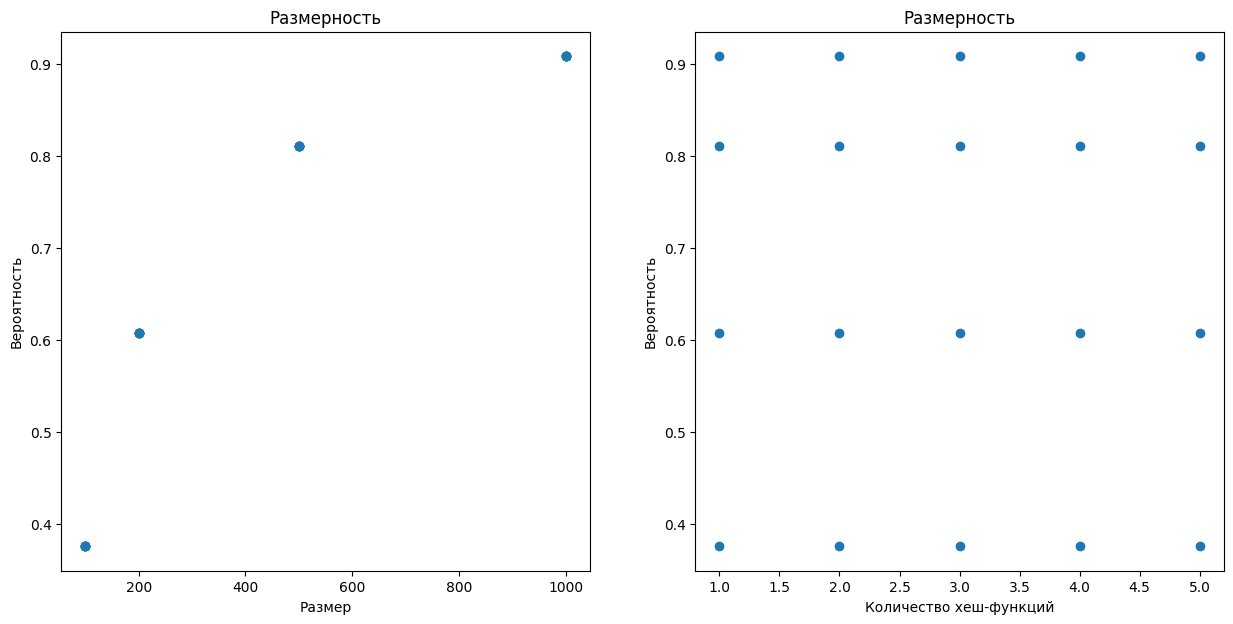

In [18]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Размерность")
plt.scatter(results[:, :, 0], results[:, :, 2])
plt.xlabel("Размер")
plt.ylabel("Вероятность")
plt.subplot(1, 2, 2)
plt.title("Размерность")
plt.scatter(results[:, :, 1], results[:, :, 2])
plt.xlabel("Количество хеш-функций")
plt.ylabel("Вероятность")
plt.show()

## Пересечение и объединение фильтров

In [22]:
def union(bloom1: CountingBloomFilter, bloom2: CountingBloomFilter):
    if bloom1.size != bloom2.size:
        raise ValueError("Bloom filters must be of the same size")
    new_bloom = CountingBloomFilter(bloom1.size, bloom1.num_hashes + bloom2.num_hashes)
    new_bloom.buckets = [max(b1, b2) for b1, b2 in zip(bloom1.buckets, bloom2.buckets)]
    return new_bloom

def intersection(bloom1: CountingBloomFilter, bloom2: CountingBloomFilter):
    if bloom1.size != bloom2.size:
        raise ValueError("Bloom filters must be of the same size")
    new_bloom = CountingBloomFilter(bloom1.size, bloom1.num_hashes + bloom2.num_hashes)
    new_bloom.buckets = [min(b1, b2) for b1, b2 in zip(bloom1.buckets, bloom2.buckets)]
    return new_bloom

Объединение

In [24]:
filter1 = CountingBloomFilter(size=10, num_hashes=2)
filter2 = CountingBloomFilter(size=10, num_hashes=3)

for i in range(5):
    filter1.add(f"{i}")
    filter2.add(f"{i}")

new_filter = union(filter1, filter2)
print(filter1.buckets)
print(filter2.buckets)
new_filter.buckets

[4, 2, 2, 2, 0, 0, 0, 0, 0, 0]
[6, 3, 3, 3, 0, 0, 0, 0, 0, 0]


[6, 3, 3, 3, 0, 0, 0, 0, 0, 0]

Пересечение

In [25]:
filter1 = CountingBloomFilter(size=10, num_hashes=2)
filter2 = CountingBloomFilter(size=10, num_hashes=3)

for i in range(5):
    filter1.add(f"{i}")
    filter2.add(f"{i}")

new_filter = intersection(filter1, filter2)
print(filter1.buckets)
print(filter2.buckets)
new_filter.buckets

[4, 2, 2, 2, 0, 0, 0, 0, 0, 0]
[6, 3, 3, 3, 0, 0, 0, 0, 0, 0]


[4, 2, 2, 2, 0, 0, 0, 0, 0, 0]